<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:170%;
            text-align:center;
            border-radius:15px;
            background-color:#419E61;
            overflow:hidden;
            font-weight:700;">
    Green Defend
    <div style="font-size:70%; font-weight:500; margin-top:5px;">
        Intelligent Plant Disease Detection and Agriculyure Support System
    </div>
</div>

<style>
    .jp-InputArea-editor {
        display: none;
    }
</style>


<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:120%;
            text-align:left;
            border-radius:15px;
            overflow:hidden;
            font-weight:700;
            background-color:#333;">
            About NoteBook
</div>

The goal of this project is to identify 38 different plant diseases from RGB images of crop leaves. By leveraging deep learning techniques, this model helps in detecting and categorizing diseases, aiding farmers and agricultural experts.

<div style="padding:10px;
            color:white;
            margin:5px;
            font-size:120%;
            text-align:left;
            border-radius:15px;
            overflow:hidden;
            font-weight:700;
            background-color:#333;">
            About Data Set
</div>


> * This dataset is recreated using offline augmentation from the original dataset.
> * This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. 
> * The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure.

## Import libraries

In [70]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D

from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import load_img, img_to_array

import warnings
warnings.filterwarnings('ignore')

In [71]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/new-plant-diseases-dataset


In [72]:
train_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/'
valid_dir = '/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/'

test_dir  ="/kaggle/input/new-plant-diseases-dataset/test"

In [73]:
image_shape = (224,224)
batch_size = 64

In [74]:
# apply scaling only becouse data already augmented

train_datagen = ImageDataGenerator(rescale=1/255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale = 1/255.)

### load training data


In [75]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset='training')

Found 56251 images belonging to 38 classes.


### load validation data (20% of training data)


In [76]:
valid_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')

Found 14044 images belonging to 38 classes.


### load test data (consider validation data as test data)


In [77]:
test_data = test_datagen.flow_from_directory(valid_dir,
                                               target_size=image_shape,
                                               batch_size=batch_size,
                                               class_mode='categorical',
                                               shuffle=False)

Found 17572 images belonging to 38 classes.


***From previous cell we know that we have 38 class***
> * 56251 images in train data
> * 14044 images in valisation data
> * 17572 images in test datata

### What are 38 classes are?

In [78]:
# show how data store 
images, labels = next(iter(train_data))
print(f'shape of image is : {images[0].shape}')
print(f'label  \n{labels[0]}')

shape of image is : (224, 224, 3)
label  
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [79]:
# show all diseases in dataset
diseases = os.listdir(train_dir)
print(diseases)

['Tomato___Late_blight', 'Tomato___healthy', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Potato___healthy', 'Corn_(maize)___Northern_Leaf_Blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Strawberry___Leaf_scorch', 'Peach___healthy', 'Apple___Apple_scab', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 'Apple___Black_rot', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Peach___Bacterial_spot', 'Apple___Cedar_apple_rust', 'Tomato___Target_Spot', 'Pepper,_bell___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Late_blight', 'Tomato___Tomato_mosaic_virus', 'Strawberry___healthy', 'Apple___healthy', 'Grape___Black_rot', 'Potato___Early_blight', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)', 'Raspberry___healthy', 'Tomato___Leaf_Mold', 'Tomato__

***We notice that we have the same plant in different class such as:***
 > * Tomato___Early_blight
 > * Tomato___Late_blight
 > * Tomato___healthy
 > * ...

***so we need to know what is the different type of plant we have***

In [80]:
# identify uniqe plant in dataset
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
print(f'number of different plants is :{len(plants)}')
print(plants)

number of different plants is :14
['Tomato', 'Grape', 'Orange', 'Soybean', 'Squash', 'Potato', 'Corn_(maize)', 'Strawberry', 'Peach', 'Apple', 'Blueberry', 'Cherry_(including_sour)', 'Pepper,_bell', 'Raspberry']


In [81]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Tomato___Late_blight                                         1851
Tomato___healthy                                             1926
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Potato___healthy                                             1824
Corn_(maize)___Northern_Leaf_Blight                          1908
Tomato___Early_blight                                        1920
Tomato___Septoria_leaf_spot                                  1745
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Strawberry___Leaf_scorch                                     1774
Peach___healthy                                              1728
Apple___Apple_scab                                           2016
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Tomato___Bacterial_spot                                      1702
Apple___Black_rot                                            1987
Blueberry___healthy                                          1816
Cherry_(including_sour)___Powdery_mildew                     1683
Peach___Bacterial_spot                                       1838
Apple___Cedar_apple_rust                                     1760
Tomato___Target_Spot                                         1827
Pepper,_bell___healthy                                       1988
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Potato___Late_blight                                         1939
Tomato___Tomato_mosaic_virus                                 1790
Strawberry___healthy                                         1824
Apple___healthy                                              2008
Grape___Black_rot                                            1888
Potato___Early_blight                                        1939
Cherry_(including_sour)___healthy                            1826
Corn_(maize)___Common_rust_                                  1907
Grape___Esca_(Black_Measles)                                 1920
Raspberry___healthy                                          1781
Tomato___Leaf_Mold                                           1882
Tomato___Spider_mites Two-spotted_spider_mite                1741
Pepper,_bell___Bacterial_spot                                1913
Corn_(maize)___healthy                                       1859

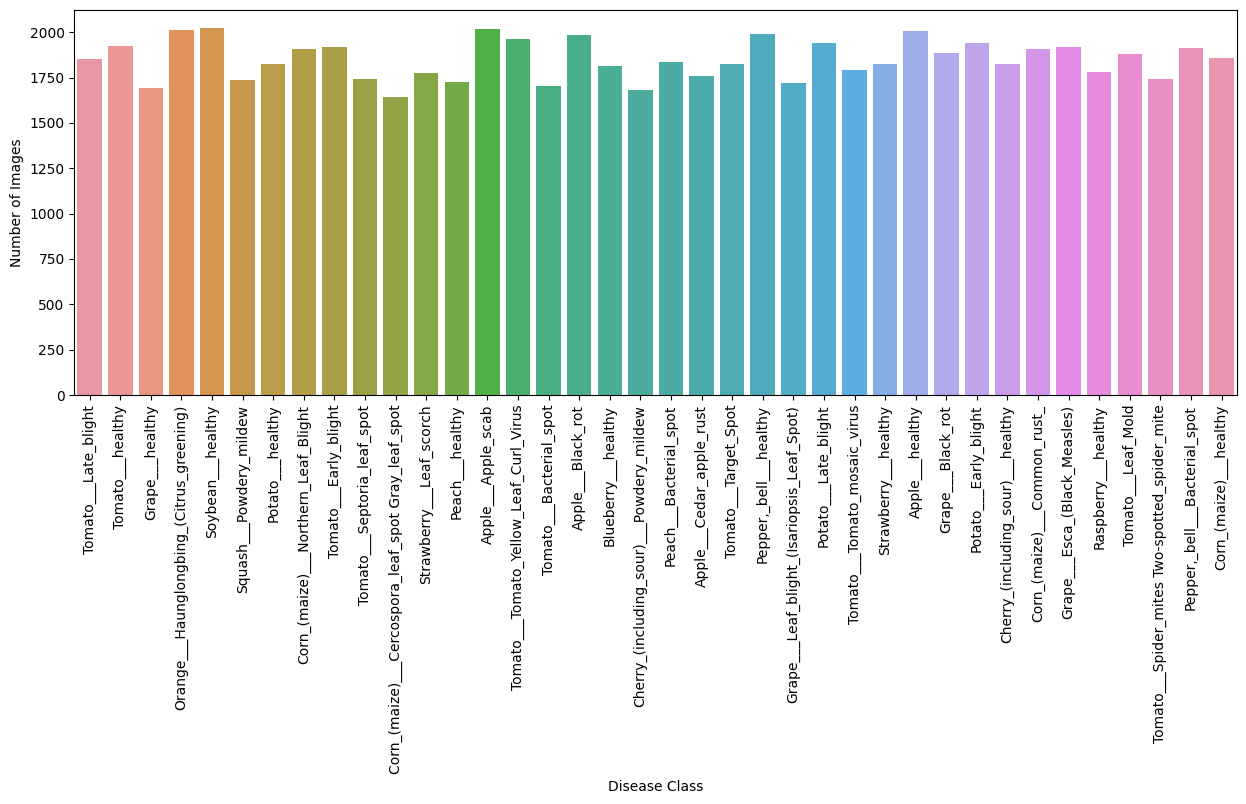

In [82]:
# show number of each class
dic = {}
for Class in diseases:
    dic[Class] = len(os.listdir(train_dir + '/' + Class))

df = pd.DataFrame(list(dic.items()), columns=["Disease Class", "Number of Images"])

plt.figure(figsize=(15,5))
sns.barplot(data=df ,x='Disease Class' ,y= 'Number of Images' )
plt.xticks(rotation=90)
plt.show()

As we notice that classes are somewhat balanced

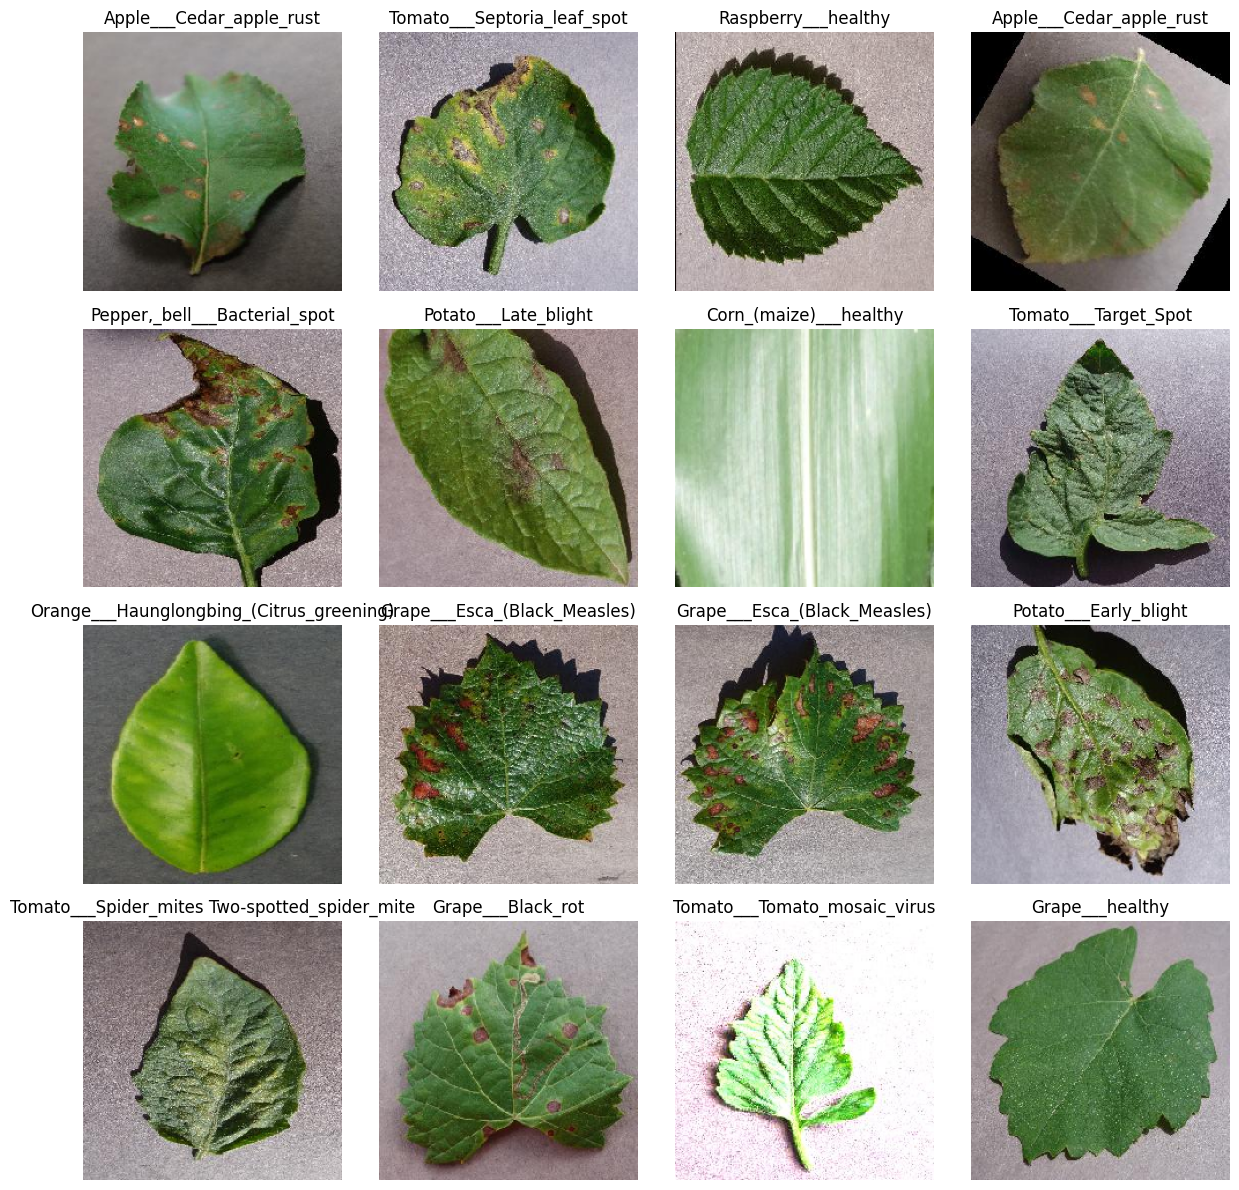

In [83]:
import random
# select a specific batch
images, labels = next(iter(train_data))

# select 16 image by random
indices = random.sample(range(len(images)), 16)
selected_images = images[indices]
selected_labels = labels[indices]

class_names = list(train_data.class_indices.keys())

# plotting
plt.figure(figsize=(12, 12))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(selected_images[i])
    plt.title(class_names[np.argmax(selected_labels[i])])  
    plt.axis("off")  

plt.tight_layout()
plt.show()

In [84]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))

    # accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [85]:
def predict_labels_and_display(model_path, test_dir='/kaggle/input/new-plant-diseases-dataset/test/test', image_size=(224, 224)):
    # load the best model
    best_model = load_model(model_path)

    true_labels = []
    predicted_labels = []
    images = []

    for filename in os.listdir(test_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')): 
            # load test images
            img_path = os.path.join(test_dir, filename)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # predict
            prediction = best_model.predict(img_array, verbose=0)
            predicted_class = np.argmax(prediction, axis=1)[0]

            # extract the label (name of image)
            true_label = filename.split('.')[0]

            # get the prediction class
            class_labels = list(train_data.class_indices.keys())
            predicted_label = class_labels[predicted_class]

            true_labels.append(true_label)
            predicted_labels.append(predicted_label)
            images.append(img)

    # randomly select three images
    selected_indices = random.sample(range(len(images)), 3)

    # show selected images
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(selected_indices):
        plt.subplot(1, 3, i + 1)
        plt.imshow(images[idx])
        plt.title(f'True: {true_labels[idx]}\nPredicted: {predicted_labels[idx]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## CNN Model

In [86]:
model = Sequential()

model.add(Conv2D(32,(3,3),activation = 'elu',input_shape=(224,224,3), kernel_initializer=GlorotNormal()))
model.add(Conv2D(32, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(64, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(Conv2D(128, (3,3), activation='elu', kernel_initializer=GlorotNormal()))
model.add(MaxPooling2D(2,2))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())

model.add(Dense(256, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(64, activation='elu', kernel_initializer=GlorotNormal()))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 220, 220, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 108, 108, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 106, 106, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 38)             │         2,470 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,446 (1.39 MB)

 Trainable params: 364,550 (1.39 MB)

 Non-trainable params: 896 (3.50 KB)

## Train the model


In [87]:
model_checkpoint = ModelCheckpoint('/kaggle/working/green_defend_cnn.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max', restore_best_weights=True)

In [88]:
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=10,
                    batch_size=64, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.3364 - loss: 2.3630
Epoch 1: val_accuracy improved from -inf to 0.54785, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 298s 327ms/step - accuracy: 0.3365 - loss: 2.3623 - val_accuracy: 0.5478 - val_loss: 1.5724
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7416 - loss: 0.8453
Epoch 2: val_accuracy improved from 0.54785 to 0.84648, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 281s 318ms/step - accuracy: 0.7417 - loss: 0.8452 - val_accuracy: 0.8465 - val_loss: 0.4702
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.8531 - loss: 0.4647
Epoch 3: val_accuracy improved from 0.84648 to 0.86670, saving model to /kaggle/working/green_defend_cnn.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 281s 318ms/step - accuracy: 0.8531 - loss: 0.4646 - val_accuracy: 0.8667 - val_loss: 0.4040
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [89]:
def plot_learning_curves_custom(history, save_path=None, color_scheme=('blue', 'orange')):
    plt.figure(figsize=(14, 5))

    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], color=color_scheme[0], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], color=color_scheme[1], linestyle='--', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.5)

    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], color=color_scheme[0], label='Training Loss')
    plt.plot(history.history['val_loss'], color=color_scheme[1], linestyle='--', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f'Plot saved as {save_path}')

    plt.show()


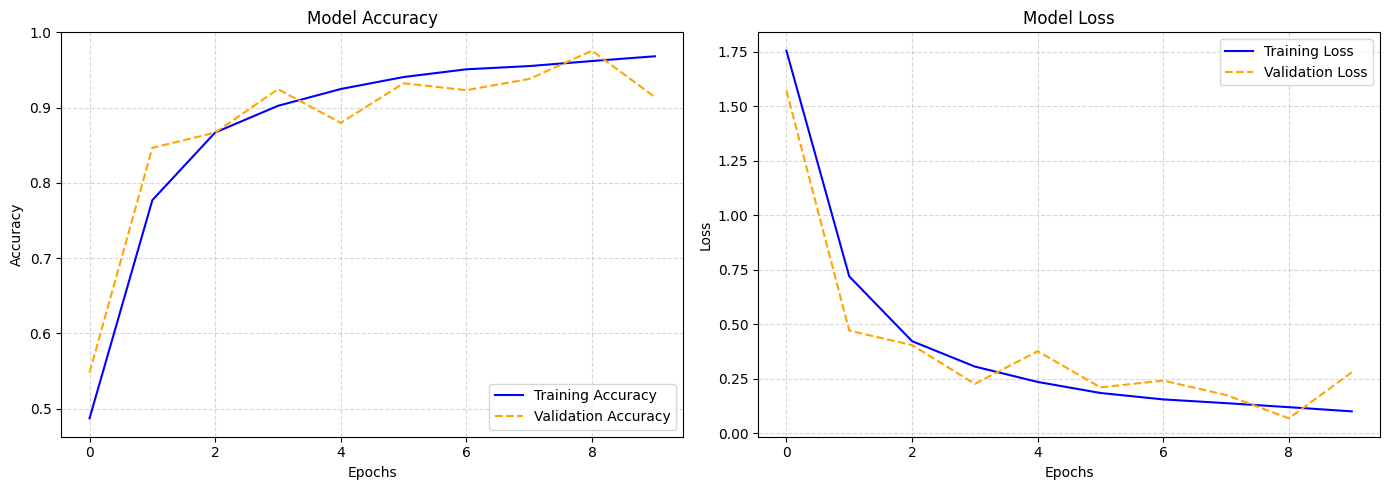

In [90]:
plot_learning_curves_custom(history)

In [91]:
# save model to use later
model.save('/kaggle/working/green_defend_cnn.keras')

In [92]:
# showe accuracy on test data (model evaluation)
best_model = load_model('/kaggle/working/green_defend_cnn.keras')

test_loss, test_accuracy = best_model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

275/275 ━━━━━━━━━━━━━━━━━━━━ 61s 219ms/step - accuracy: 0.9846 - loss: 0.0449
Test Loss: 0.0631
Test Accuracy: 0.9793


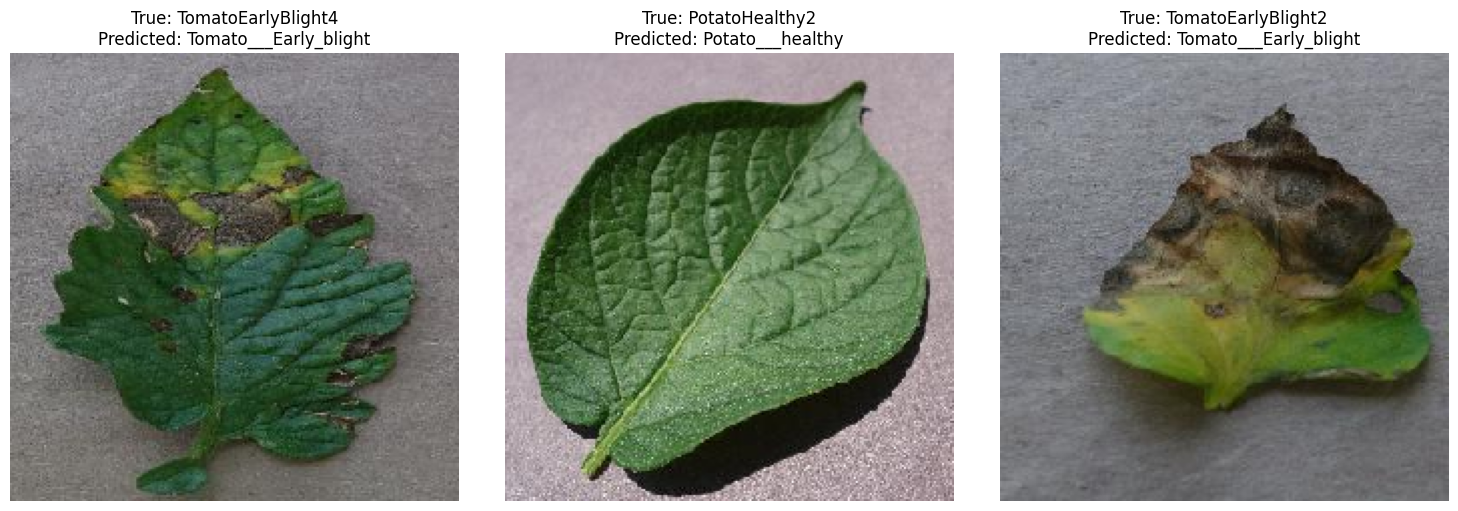

In [93]:
# show random sample of prediction of model on test data
predict_labels_and_display('/kaggle/working/green_defend_cnn.keras')

## Evaluate model performance

In [94]:
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

def evaluate_model(model_path, test_data, model_name):
    # load model
    model = tf.keras.models.load_model(model_path)

    # predict
    y_pred = model.predict(test_data)
    y_pred_classes = y_pred.argmax(axis=1)

    # get true classes
    y_true = test_data.classes

    class_labels = list(test_data.class_indices.keys())

    accuracy = accuracy_score(y_true, y_pred_classes)

    report = classification_report(y_true, y_pred_classes, target_names=class_labels, output_dict=True)

    df_report = pd.DataFrame(report).transpose()

    df_report.loc['accuracy'] = [accuracy, None, None, None]

    df_report['model'] = model_name

    return df_report

cnn_model_path = 'green_defend_cnn.keras'

cnn_report = evaluate_model(cnn_model_path, test_data, 'CNN')

all_reports = pd.concat([cnn_report])

all_reports = all_reports.reset_index().rename(columns={'index': 'metric'})

all_reports

275/275 ━━━━━━━━━━━━━━━━━━━━ 44s 160ms/step


metric  precision    recall  \
0                                  Apple___Apple_scab   0.990079  0.990079   
1                                   Apple___Black_rot   0.982036  0.989940   
2                            Apple___Cedar_apple_rust   0.993228  1.000000   
3                                     Apple___healthy   0.984127  0.988048   
4                                 Blueberry___healthy   0.974249  1.000000   
5            Cherry_(including_sour)___Powdery_mildew   1.000000  0.980998   
6                   Cherry_(including_sour)___healthy   0.947808  0.995614   
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   0.950904  0.897561   
8                         Corn_(maize)___Common_rust_   0.997899  0.995807   
9                 Corn_(maize)___Northern_Leaf_Blight   0.919840  0.962264   
10                             Corn_(maize)___healthy   1.000000  1.000000   
11                                  Grape___Black_rot   0.981132  0.991525   
12                       Grape___Esca_(Black_Measles)   0.983471  0.991667   
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   0.997658  0.990698   
14                                    Grape___healthy   1.000000  0.992908   
15           Orange___Haunglongbing_(Citrus_greening)   0.988212  1.000000   
16                             Peach___Bacterial_spot   0.993377  0.980392   
17                                    Peach___healthy   0.988399  0.986111   
18                      Pepper,_bell___Bacterial_spot   0.995745  0.979079   
19                             Pepper,_bell___healthy   0.983158  0.939638   
20                              Potato___Early_blight   0.987780  1.000000   
21                               Potato___Late_blight   0.958000  0.987629   
22                                   Potato___healthy   0.982684  0.995614   
23                                Raspberry___healthy   0.997727  0.986517   
24                                  Soybean___healthy   0.988119  0.988119   
25                            Squash___Powdery_mildew   1.000000  0.997696   
26                           Strawberry___Leaf_scorch   1.000000  0.986486   
27                               Strawberry___healthy   0.991285  0.997807   
28                            Tomato___Bacterial_spot   0.987835  0.955294   
29                              Tomato___Early_blight   0.970522  0.891667   
30                               Tomato___Late_blight   0.975225  0.935205   
31                                 Tomato___Leaf_Mold   0.984881  0.970213   
32                        Tomato___Septoria_leaf_spot   0.985612  0.942661   
33      Tomato___Spider_mites Two-spotted_spider_mite   0.946309  0.972414   
34                               Tomato___Target_Spot   0.865643  0.986871   
35             Tomato___Tomato_Yellow_Leaf_Curl_Virus   0.985772  0.989796   
36                       Tomato___Tomato_mosaic_virus   0.982301  0.991071   
37                                   Tomato___healthy   0.995772  0.979210   
38                                           accuracy   0.979342       NaN   
39                                          macro avg   0.979916  0.979121   
40                                       weighted avg   0.979911  0.979342   

    f1-score  support model  
0   0.990079    504.0   CNN  
1   0.985972    497.0   CNN  
2   0.996602    440.0   CNN  
3   0.986083    502.0   CNN  
4   0.986957    454.0   CNN  
5   0.990408    421.0   CNN  
6   0.971123    456.0   CNN  
7   0.923463    410.0   CNN  
8   0.996852    477.0   CNN  
9   0.940574    477.0   CNN  
10  1.000000    465.0   CNN  
11  0.986301    472.0   CNN  
12  0.987552    480.0   CNN  
13  0.994166    430.0   CNN  
14  0.996441    423.0   CNN  
15  0.994071    503.0   CNN  
16  0.986842    459.0   CNN  
17  0.987254    432.0   CNN  
18  0.987342    478.0   CNN  
19  0.960905    497.0   CNN  
20  0.993852    485.0   CNN  
21  0.972589    485.0   CNN  
22  0.989107    456.0   CNN  
23  0.992090    445.0   CNN  
24  0.988119    505.

In [ ]:
final_report =all_reports[all_reports['metric'] == 'macro avg']
final_report

metric  precision    recall  f1-score  support model
39  macro avg   0.979916  0.979121  0.979245  17572.0   CNN